In [ ]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns

from causalai.simulation import simulate_matches

import dowhy
import networkx as nx
# import pgmpy

from pgmpy.models import DiscreteBayesianNetwork
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from pgmpy.inference import CausalInference

import arviz as az
import pymc as pm

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [2]:
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
seed = sum(map(ord, "eda-simulation"))
rng = np.random.default_rng(seed)

In [3]:
# Configuration parameters
N_MATCHES = 10000  # Number of matches to simulate
CSV_PATH = None  # Path to existing CSV file (None to simulate fresh data)
OUTPUT_DIR = pathlib.Path("eda_outputs")  # Directory to save outputs
OUTCOMES = [
    "shots",
    "goals",
    "passes",
    "tackles",
    "clearances",
    "blocks",
    "pressures",
    "dribbles",
    "saves",
    "fouls",
    "cards",
]

In [4]:
def nuts_kwargs(seed, *args, **kwargs):
    return {
        "nuts_sampler": "nutpie",
        "tune": 300,
        "draws": 500,
        "cores": 8,
        "chains": 8,
        "random_seed": seed,
    }

In [5]:
df = simulate_matches(n_matches=N_MATCHES, seed=seed)

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()


Dataset shape: (10000, 17)
Columns: ['off_old', 'def_old', 'score_diff', 'sub', 'off_new', 'def_new', 'shots', 'goals', 'passes', 'tackles', 'clearances', 'blocks', 'pressures', 'dribbles', 'saves', 'fouls', 'cards']


,off_old,def_old,score_diff,sub,off_new,def_new,shots,goals,passes,tackles,clearances,blocks,pressures,dribbles,saves,fouls,cards
0,59.829088,50.311367,1,0,59.829088,50.311367,7,1,68,6,3,3,6,7,4,1,0
1,66.932724,55.248509,1,0,66.932724,55.248509,6,1,70,4,5,6,4,8,4,0,0
2,45.705586,52.293501,0,1,52.311915,45.083977,5,2,40,5,9,2,4,1,3,1,0
3,33.402367,39.559093,0,1,39.212239,33.273649,6,0,36,2,2,1,4,1,2,0,0
4,47.139818,49.026986,-1,0,47.139818,49.026986,3,1,39,4,1,3,2,6,2,0,0


In [6]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
off_old,10000.0,55.07,10.10,13.41,48.09,54.96,61.91,91.91
def_old,10000.0,54.94,7.13,28.86,50.10,54.92,59.65,83.58
score_diff,10000.0,0.20,0.83,-3.00,0.00,0.00,1.00,3.00
sub,10000.0,0.50,0.50,0.00,0.00,1.00,1.00,1.00
off_new,10000.0,57.00,9.96,13.41,50.21,56.86,63.82,97.42
def_new,10000.0,53.04,8.43,20.54,47.25,53.01,58.83,83.58
shots,10000.0,6.15,2.75,0.00,4.00,6.00,8.00,19.00
goals,10000.0,0.92,0.97,0.00,0.00,1.00,1.00,6.00
passes,10000.0,55.93,12.70,15.00,47.00,55.00,64.00,109.00
tackles,10000.0,5.73,2.67,0.00,4.00,5.00,7.00,17.00


In [7]:
print("\nTreatment Distribution:")
print(f"  Substitution rate: {df['sub'].mean():.3f} ({df['sub'].sum()}/{len(df)})")
print(f"  No substitution: {len(df[df['sub'] == 0])} ({len(df[df['sub'] == 0]) / len(df):.1%})")
print(f"  Substitution: {len(df[df['sub'] == 1])} ({len(df[df['sub'] == 1]) / len(df):.1%})")


Treatment Distribution:
  Substitution rate: 0.504 (5039/10000)
  No substitution: 4961 (49.6%)
  Substitution: 5039 (50.4%)


## Treatment assignment mechanism

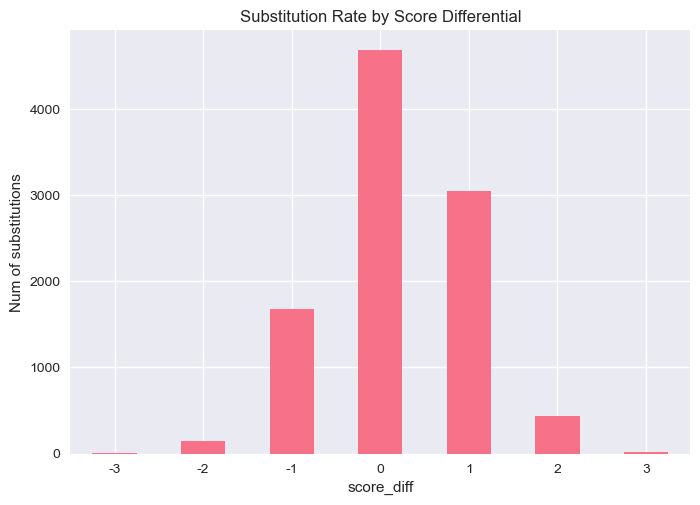

In [8]:
df.groupby("score_diff")["sub"].count().plot.bar(
    rot=0, ylabel="Num of substitutions", title="Substitution Rate by Score Differential"
);

The propensity score estimates the probability that a team receives a substitution given their observed characteristics.

This means: "What is the probability that a team makes a substitution, given their offensive strength, defensive strength, and current score differential?"

#### How It's Calculated:
- Input Variables: `off_old`, `def_old`, `score_diff` (the confounders)
- Model: Logistic regression trained to predict substitution decisions
- Output: A probability between 0 and 1 for each team

#### Why This Matters for Causal Inference:

1. Treatment Assignment Mechanism

The propensity score reveals when teams are most likely to make substitutions:
- Teams trailing (negative score_diff) → Higher substitution probability
- Teams leading (positive score_diff) → Lower substitution probability
- Stronger teams might have different substitution patterns

2. Confounder Control
The propensity score captures all the information about confounders that affect both:
- Treatment assignment (when substitutions happen)
- Outcomes (match performance)

3. Causal Assumption Validation
The code checks for overlap in propensity scores: This validates the positivity assumption - that teams with similar characteristics could potentially be in either treatment group.

#### In our soccer context:

- High propensity score (e.g., 0.8): Teams that are very likely to substitute (probably losing, weaker teams)
- Low propensity score (e.g., 0.2): Teams that rarely substitute (probably winning, stronger teams)
- Medium propensity score (e.g., 0.5): Teams where substitution is uncertain

This helps understand the selection bias in our data and is crucial for implementing methods like propensity score matching or weighting to get unbiased causal estimates of substitution effects.

In [9]:
X_propensity = df[["off_old", "def_old", "score_diff"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_propensity)

propensity_model = LogisticRegression(random_state=seed).fit(X_scaled, df["sub"])
df["propensity_score"] = propensity_model.predict_proba(X_scaled)[:, 1]

print(
    f"  Propensity score range: [{df['propensity_score'].min():.3f}, {df['propensity_score'].max():.3f}]"
)
print(f"  Mean propensity (treated): {df[df['sub'] == 1]['propensity_score'].mean():.3f}")
print(f"  Mean propensity (control): {df[df['sub'] == 0]['propensity_score'].mean():.3f}")

  Propensity score range: [0.007, 0.997]
  Mean propensity (treated): 0.644
  Mean propensity (control): 0.361


In [10]:
treated_ps = df[df["sub"] == 1]["propensity_score"]
control_ps = df[df["sub"] == 0]["propensity_score"]
overlap_exists = control_ps.min() < treated_ps.max() and treated_ps.min() < control_ps.max()
print(f"  Propensity score overlap: {'✓' if overlap_exists else '✗'}")

  Propensity score overlap: ✓


## Define the causal structure

In [17]:
outcome_label = "outcome"
edges = [
    # Baseline team characteristics
    # Confounders affecting both treatment and outcomes
    ("off_old", "score_diff"),
    ("off_old", "def_old"),
    ("off_old", "off_new"),
    ("def_old", "def_new"),
    ("def_old", "score_diff"),
    ("score_diff", "sub"),  # Score affects substitution decision
    # Treatment effects
    ("sub", "off_new"),
    ("sub", "def_new"),
    # Outcome generation
    ("off_new", outcome_label),
    ("def_new", outcome_label),
    # Score differential affects outcomes (confounder)
    ("score_diff", outcome_label),
]
dag = DiscreteBayesianNetwork(edges)

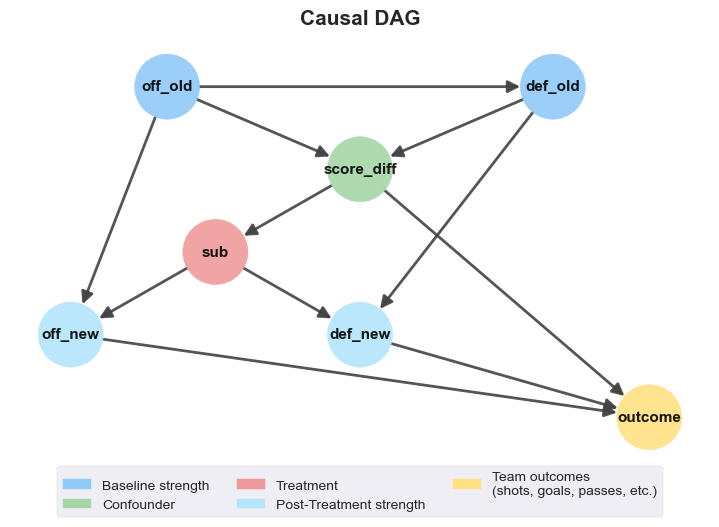

In [18]:
# Manual layout for clarity (top-down)
pos = {
    "off_old": (2, 8),
    "def_old": (6, 8),
    "score_diff": (4, 6.5),
    "sub": (2.5, 5),
    "off_new": (1, 3.5),
    "def_new": (4, 3.5),
    outcome_label: (7, 2),
}

# Node color mapping
node_colors = {
    "off_old": "#90caf9",  # blue: baseline
    "def_old": "#90caf9",  # baseline
    "score_diff": "#a5d6a7",  # green: confounder
    "sub": "#ef9a9a",  # red: treatment
    "off_new": "#b3e5fc",  # cyan: post-treat
    "def_new": "#b3e5fc",  # post-treat
    outcome_label: "#ffe082",  # orange: outcome
}

# Draw the DAG
plt.figure(figsize=(7, 4))
nx.draw(
    dag,
    pos,
    with_labels=True,
    node_color=[node_colors[n] for n in dag.nodes()],
    node_size=2200,
    font_size=11,
    font_weight="bold",
    arrows=True,
    arrowsize=18,
    edge_color="#424242",
    width=2,
    alpha=0.9,
)

legend_elements = [
    mpatches.Patch(color="#90caf9", label="Baseline strength"),
    mpatches.Patch(color="#a5d6a7", label="Confounder"),
    mpatches.Patch(color="#ef9a9a", label="Treatment"),
    mpatches.Patch(color="#b3e5fc", label="Post-Treatment strength"),
    mpatches.Patch(color="#ffe082", label="Team outcomes\n(shots, goals, passes, etc.)"),
]
plt.legend(
    handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.18), ncol=3, frameon=True
)
plt.title("Causal DAG", fontsize=15, fontweight="bold", pad=20)
plt.axis("off");

In [19]:
dseps = dag.get_independencies()
dseps

(def_new ⟂ off_new | sub, off_old)
(off_old ⟂ outcome | def_new, off_new, score_diff)
(def_old ⟂ outcome | def_new, off_new, score_diff)
(sub ⟂ outcome | def_new, off_new, score_diff)
(off_new ⟂ score_diff | sub, off_old)
(sub ⟂ off_old | score_diff)
(def_old ⟂ off_new | sub, off_old)
(def_new ⟂ score_diff | def_old, sub)
(def_old ⟂ sub | score_diff)
(def_new ⟂ off_old | def_old, sub)

In [ ]:
# Finds the minimal d-separating set for start and end.
# (sub ⟂ outcome | def_new, off_new, score_diff)
dag.minimal_dseparator(start="sub", end="outcome")

{'def_new', 'off_new', 'score_diff'}

In [ ]:
# Returns a minimal adjustment set for identifying the causal effect of X on Y
infer = CausalInference(dag)
infer.get_minimal_adjustment_set("sub", "outcome")

# but we probably wanna use the fullest adjustment set, since we have more data than necessary here
infer.get_all_adjustment_sets("sub", "outcome")

{'score_diff'}

In [ ]:
# TODOs:
# - Update DAG (according to simulation.py), adjustment set (https://pgmpy.org/exact_infer/causal.html) and plots (with causal_eda.py and 01_eda.ipynb)
# - Instead of simulated data, train GAN to generate data resembling the Statsbomb data
# - standardize everything for the models?
# - Write models and deep net (with PyTorch, NumPyro, ChiRho), then recover treatment effects from simulation!

ALL THAT'S BELOW THIS NEEDS TO BE DELETED OR EDITED, ACCORDING TO THE TODOs ABOVE

To test if d-separation in the DAG (e.g `score_diff ⊥ def_new | sub`) is confirmed by _statistical_ independence in the data, we can do a Bayesian regression of `score_diff ~ def_new + sub` and check if the coefficient on `def_new` is practically equal to 0.

d-separation means `def_new` provides no additional information about `score_diff` once we know `sub`. The Bayesian approach gives us full posterior distributions over parameters, allowing uncertainty quantification.

In [ ]:
print("=" * 60)
print("FITTING MODELS FOR EACH D-SEPARATION ASSERTION")
print("=" * 60)

# Iterate through all d-separation assertions
print(f"Total number of d-separation assertions: {len(dseps.get_assertions())}")
print()
for dsep in dseps.get_assertions():
    print(f"Assertion: {dsep}")
    target_var, independent_from, conditioning_vars = (
        list(dsep.get_assertion()[0])[0],
        list(dsep.get_assertion()[1]),
        list(dsep.get_assertion()[2]),  # can be empty
    )

    print(f"  Target variable: {target_var}")
    print(f"  Variable to test (should have coeff ≈ 0): {independent_from}")
    print(f"  Conditioning variables: {conditioning_vars}")
    print()

    coeff_names = ["intercept"] + independent_from + conditioning_vars
    with pm.Model(coords={"coeffs": coeff_names}) as ci_model:
        betas = pm.Normal(
            "betas",
            mu=0,
            sigma=[10] + [5] * len(independent_from + conditioning_vars),
            dims="coeffs",
        )
        noise = pm.Exponential("noise", 1)

        mu = betas[0] + pm.math.dot(df[independent_from + conditioning_vars].to_numpy(), betas[1:])

        if target_var == "outcome":
            target_var = rng.choice(OUTCOMES)
            pm.Poisson(target_var, mu=pm.math.exp(mu), observed=df[target_var].to_numpy())
        elif target_var == "sub":
            pm.Bernoulli(target_var, p=pm.math.sigmoid(mu), observed=df[target_var].to_numpy())
        else:
            pm.Normal(
                "y",
                mu=mu,
                sigma=noise,
                observed=df[target_var].to_numpy(),
            )

        idata = pm.sample(
            nuts_sampler="nutpie",
            nuts_sample_kwargs={"progress_bar": False},
            tune=300,
            draws=500,
            cores=8,
            chains=8,
            random_seed=seed,
        )

    coeff_samples = idata.posterior["betas"].sel(coeffs=independent_from).to_numpy().flatten()

    # Compute statistics
    mean_coeff = coeff_samples.mean()
    ci_95 = np.percentile(coeff_samples, [2.5, 97.5])
    prob_near_zero = np.mean(np.abs(coeff_samples) < 0.01)

    print(f"\n{independent_from} coefficient:")
    print(f"  Mean: {mean_coeff:.6f}")
    print(f"  95% CI: [{ci_95[0]:.6f}, {ci_95[1]:.6f}]")
    print(f"  P(|coeff| < 0.01): {prob_near_zero:.3f}")
    print(f"  CI includes 0: {'Yes' if ci_95[0] <= 0 <= ci_95[1] else 'No'}")

    if prob_near_zero > 0.95 and ci_95[0] <= 0 <= ci_95[1]:
        print("  ✅ Strong evidence for conditional independence")
    elif ci_95[0] <= 0 <= ci_95[1]:
        print("  🟡 Weak evidence for conditional independence")
    else:
        print("  ❌ Evidence against conditional independence")

    print("-" * 40)

FITTING MODELS FOR EACH D-SEPARATION ASSERTION
Total number of d-separation assertions: 13

Assertion: (off_old ⟂ off_new | sub)
  Target variable: off_old
  Variable to test (should have coeff ≈ 0): ['off_new']
  Conditioning variables: ['sub']



Progress,Draws,Divergences,Step Size,Gradients/Draw
,800,0,0.36,23
,800,0,0.39,7
,800,0,0.40,15
,800,0,0.49,15
,800,0,0.42,15
,800,0,0.46,15
,800,0,0.39,15
,800,0,0.40,7



['off_new'] coefficient:
  Mean: 0.960592
  95% CI: [0.955442, 0.966204]
  P(|coeff| < 0.01): 0.000
  CI includes 0: No
  ❌ Evidence against conditional independence
----------------------------------------
Assertion: (sub ⟂ outcome | off_new, def_new, score_diff)
  Target variable: sub
  Variable to test (should have coeff ≈ 0): ['outcome']
  Conditioning variables: ['off_new', 'def_new', 'score_diff']



KeyError: "['outcome'] not in index"

In [55]:
# Effect on treatment assignment
score_sub_corr = df["score_diff"].corr(df["sub"])
print(f"  Correlation between score_diff and sub: {score_sub_corr:.3f}")

  Correlation between score_diff and sub: -0.522


In [ ]:
print("\n2. Effect on Outcomes:")
for outcome in outcome_cols:
    corr = df["score_diff"].corr(df[outcome])
    print(f"  {outcome}: {corr:.3f}")


2. Effect on Outcomes:
  shots: -0.166
  goals: -0.065
  passes: 0.560
  tackles: 0.358
  clearances: 0.430
  blocks: 0.375
  pressures: 0.046
  dribbles: -0.109
  saves: 0.397
  fouls: 0.002
  cards: 0.009


In [ ]:


    # Backdoor path analysis (update according to adjustment sets found above)
    print("\n3. Backdoor Paths Identified:")
    print("  score_diff -> sub -> off_new/def_new -> outcomes")
    print("  score_diff -> outcomes (direct effect)")
    print("  off_old/def_old -> score_diff -> sub -> outcomes")
    print("  off_old/def_old -> score_diff -> outcomes")

    # Visualize confounder effects
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, outcome in enumerate(outcome_cols):
        # Scatter plot with regression line
        axes[i].scatter(df["score_diff"], df[outcome], alpha=0.6, s=20)

        # Add regression line
        z = np.polyfit(df["score_diff"], df[outcome], 1)
        p = np.poly1d(z)
        axes[i].plot(df["score_diff"], p(df["score_diff"]), "r--", alpha=0.8)

        axes[i].set_xlabel("Score Differential")
        axes[i].set_ylabel(outcome.title())
        axes[i].set_title(f"{outcome.title()} vs Score Differential")
        axes[i].grid(True, alpha=0.3)